# Estrategia Short Put

In [1]:
# Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
import emoji
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt

In [2]:
# Definir función para extraer datos reales
def obtener_cadena_opciones(ticker: str):

    """
    Obtiene la cadena de opciones para una fecha específica.
    """

    # Crear Instancia
    subyacente = yf.Ticker(ticker=ticker)
    # Obtener Precio más reciente
    hist = subyacente.history(period="1d")
    precio_actual = hist["Close"].iloc[-1]
    # Seleccionar Fecha de Vencimiento
    fecha_vencimiento = subyacente.options
    fecha_objetivo = fecha_vencimiento[1]
    # Extraer Puts
    puts = subyacente.option_chain(date=fecha_objetivo).puts

    return round(precio_actual, 4), puts

# Comprobar funcionamiento
ticker = "AAPL"
precio_actual, puts = obtener_cadena_opciones(ticker)
print(f"Precio Actual de {ticker}: ${precio_actual:,}\n")
puts

Precio Actual de AAPL: $201.45



,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250620P00005000,2025-05-12 17:38:15+00:00,5.0,0.01,0.00,0.01,0.0,0.0,1,5134,6.250002,False,REGULAR,USD
1,AAPL250620P00010000,2025-06-09 18:27:26+00:00,10.0,0.01,0.00,0.01,0.0,0.0,10,3189,5.000004,False,REGULAR,USD
2,AAPL250620P00015000,2025-04-25 13:30:02+00:00,15.0,0.01,0.00,0.01,0.0,0.0,48,61,4.375005,False,REGULAR,USD
3,AAPL250620P00020000,2025-06-04 13:30:16+00:00,20.0,0.01,0.00,0.01,0.0,0.0,1,11,3.875000,False,REGULAR,USD
4,AAPL250620P00025000,2025-04-29 17:44:20+00:00,25.0,0.01,0.00,0.01,0.0,0.0,20,102,3.500001,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,AAPL250620P00320000,2025-06-06 18:23:41+00:00,320.0,114.91,118.20,119.25,0.0,0.0,1,1,1.101567,True,REGULAR,USD
72,AAPL250620P00330000,2025-06-04 15:44:23+00:00,330.0,126.00,127.85,129.35,0.0,0.0,1,0,1.011724,True,REGULAR,USD
73,AAPL250620P00340000,2025-03-27 19:55:00+00:00,340.0,115.65,129.90,131.50,0.0,0.0,1,0,0.000010,True,REGULAR,USD
74,AAPL250620P00350000,2024-12-27 17:10:43+00:00,350.0,96.90,113.25,114.20,0.0,0.0,1,0,0.000010,True,REGULAR,USD


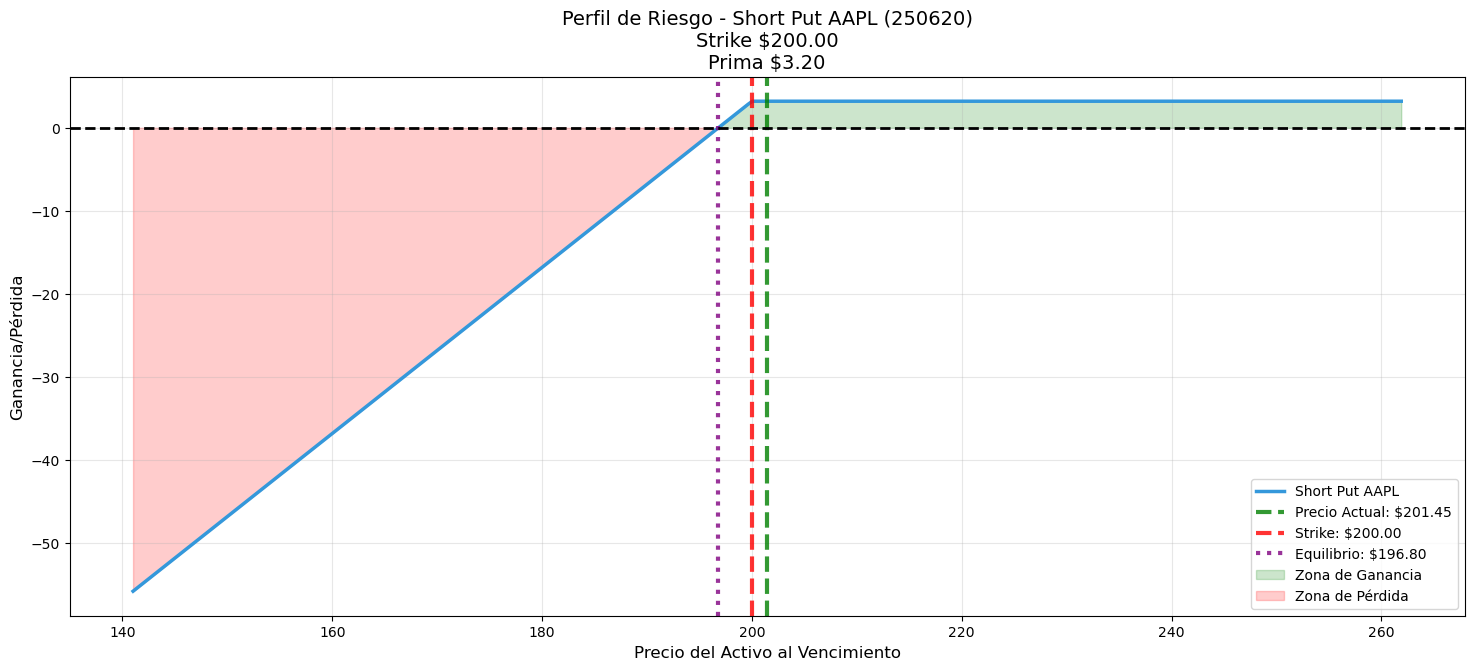


📊 RESUMEN ANALÍTICO - SHORT PUT AAPL
- Activo:                   AAPL
- Precio Actual:            $201.45
- Strike Seleccionado:      $200.00
- Prima Recibida:           $3.20
- Punto de Equilibrio:      $196.80

------------------------------------------------------------
- Máxima Ganancia:          💰 $3.20 (si el activo >= $200.00)
- Máxima Pérdida:           ⚠️ $196.80 (si el activo -> 0)

------------------------------------------------------------

Situación actual:         🟢 OUT OF THE MONEY (OTM)
Distancia al strike:      0.72%



In [3]:
# Definir Función de Visualización para Estrategia
def estrategia_short_put(ticker: str, strike: float, puts_df: pd.DataFrame, precio_actual: float):

    """
    Visualiza y analiza el perfil de riesgo/beneficio de una estrategia short put
    """

    # Encontrar Datos del Strike
    info_strike = puts_df[puts_df["strike"] == strike]
    # Validar que exista la información
    if len(info_strike) == 0:
        raise ValueError(f"Strike no disponible. Strikes válidos: {puts_df['strike'].unique()}")

    # Obtener datos relevantes
    prima_recibida = round(float(info_strike["bid"].iloc[0]), 2)
    fecha = info_strike["contractSymbol"].iloc[0][-15:-9]

    # Calcular perfiles de riesgo
    precios_finales = np.linspace(precio_actual * 0.70, precio_actual * 1.30, 300)
    payoff = prima_recibida - np.maximum(strike - precios_finales, 0)
    punto_equilibrio = strike - prima_recibida
    max_ganancia = prima_recibida
    max_perdida = strike - prima_recibida 

    # Plot
    fig, ax = plt.subplots(figsize=(18, 7))

    # Gráfico principal
    ax.plot(precios_finales, payoff, label=f"Short Put {ticker}", color="#3498db", linewidth=2.5)

    # Líneas de referencia
    lineas_referencia = [

        (precio_actual, f"Precio Actual: ${precio_actual:,.2f}", "green", "--"),
        (strike, f"Strike: ${strike:,.2f}", "red", "--"),
        (punto_equilibrio, f"Equilibrio: ${punto_equilibrio:,.2f}", "purple", ":")
        
    ]
    # Graficar
    for precio, label, color, estilo in lineas_referencia:
        ax.axvline(x=precio, color=color, linestyle=estilo, lw=3, alpha=0.80, label=label)

    # Añadir una línea en y=0
    ax.axhline(y=0, color="black", linestyle="--", linewidth=2)

    # Áreas sombreadas (Beneficio o Pérdida)
    ax.fill_between(x=precios_finales, y1=payoff, y2=0, where=(payoff >= 0), color="green", alpha=0.2, label="Zona de Ganancia")
    ax.fill_between(x=precios_finales, y1=payoff, y2=0, where=(payoff < 0), color="red", alpha=0.2, label="Zona de Pérdida")

    # Configuración del gráfico
    ax.set_title(f"Perfil de Riesgo - Short Put {ticker} ({fecha})\nStrike ${strike:,.2f}\nPrima ${prima_recibida:.2f}", fontsize=14)
    ax.set_xlabel("Precio del Activo al Vencimiento", fontsize=12)
    ax.set_ylabel("Ganancia/Pérdida", fontsize=12)
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(alpha=0.3)
    plt.show()

    # Resumen detallado
    print("\n" + "=" * 60)
    print(f"{emoji.emojize(':bar_chart:')} RESUMEN ANALÍTICO - SHORT PUT {ticker}")
    print("=" * 60)
    print(f"- {'Activo:':<25} {ticker}")
    print(f"- {'Precio Actual:':<25} ${precio_actual:,.2f}")
    print(f"- {'Strike Seleccionado:':<25} ${strike:,.2f}")
    print(f"- {'Prima Recibida:':<25} ${prima_recibida:,.2f}")
    print(f"- {'Punto de Equilibrio:':<25} ${punto_equilibrio:,.2f}")
    print("\n" + "-" * 60)
    print(f"- {'Máxima Ganancia:':<25} {emoji.emojize(':money_bag:')} ${max_ganancia:,.2f} (si el activo >= ${strike:.2f})")
    print(f"- {'Máxima Pérdida:':<25} {emoji.emojize(':warning:')} ${max_perdida:,.2f} (si el activo -> 0)")
    print("\n" + "-" * 60)

    # Análisis de Situación Actual
    situacion = ""
    if precio_actual > strike:
        situacion = f"{emoji.emojize(':green_circle:')} OUT OF THE MONEY (OTM)"
    elif precio_actual < strike:
        situacion = f"{emoji.emojize(':red_circle:')} IN THE MONEY (ITM)"
    else:
        situacion = f"{emoji.emojize(':yellow_circle:')} AT THE MONEY (ATM)"

    print(f"\n{'Situación actual:':<25} {situacion}")
    print(f"{'Distancia al strike:':<25} {abs((strike - precio_actual) / precio_actual * 100):.2f}%")
    print("=" * 60 + "\n")

# Comprobar funcionamiento
strike = 200
estrategia_short_put(ticker=ticker, strike=strike, puts_df=puts, precio_actual=precio_actual)

## Plot Interactivo

In [4]:
# Función para generar el dropdown de strikes disponibles
def generar_interfaz_short_put(ticker: str):

    """
    Función para generar un plot interactivo para un short put.
    """

    # Extraer Cadena de Opciones
    precio_actual, puts = obtener_cadena_opciones(ticker=ticker)

    # Extraer strikes disponibles
    strikes_disponibles = puts["strike"].unique()
    strikes_disponibles.sort()

    # Crear Menú Desplegable con todos los precios de ejercicio
    widget_strike = Dropdown(

        options=strikes_disponibles,
        value=strikes_disponibles[len(strikes_disponibles) // 2],
        description="Strike:",
        style={"description_width": "initial"}
        
    )

    # Función interna para interactividad
    def actualizar_plot(strike):
        estrategia_short_put(ticker, strike, puts, precio_actual)

    # Mostrar el widget interactivo
    interact(actualizar_plot, strike=widget_strike)

# Ejemplo de uso
generar_interfaz_short_put("AAPL")

interactive(children=(Dropdown(description='Strike:', index=38, options=(5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35…

### Fórmula Estimada del Margen para un Short Put

Margen Requerido = Precio Prima Recibida + Max[(20% * Precio de Subyacente - Cantidad fuere de dinero), 10% * Precio de Ejericio]

In [5]:
# Parámetros
precio_activo = 100
precio_ejercicio = 95
prima_recibida = 3 * 100

# Cálculos
cantidad_fuera_dinero = max(0, precio_ejercicio - precio_activo) * 100
parte1 = 0.20 * precio_activo * 100 - cantidad_fuera_dinero
parte2 = 0.10 * precio_ejercicio * 100

margen_por_contrato = prima_recibida + max(parte1, parte2)

print(f"El Margen para esta posición es de ${margen_por_contrato:,.2f} USD")

El Margen para esta posición es de $2,300.00 USD


### Recordatorio:

    - Una posición short put genera ganancias si el precio del activo subyacente se mantiene por encima del precio de ejercicio, permitiendo al vendedor
    conservar la prima recibida sin ser ejercido.
    - El riesgo principal de un short put es que, si el precio del activo cae por debajo del strike, el vendedor debe comprar el activo a un precio mayor, generando pérdidas potenciales significativas.